In [ ]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from rendering import init_renderer, rasterize_mesh
import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()


In [ ]:
device = torch.device("cuda:0")
mesh = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device).cpu()

In [ ]:
R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

In [467]:
res = 512
H, W = res, res

renderer = init_renderer(cameras, resolution=res)
fragments, depth_map = rasterize_mesh(renderer, mesh)

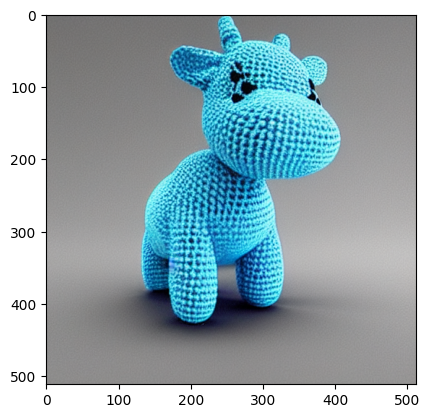

In [469]:
from PIL import Image
import torchvision.transforms as transforms

to_tensor = transforms.ToTensor()

image = Image.open('data/example/view.png').resize((res,res))
feature_tensor = to_tensor(image).permute(1,2,0)
plt.imshow(feature_tensor)

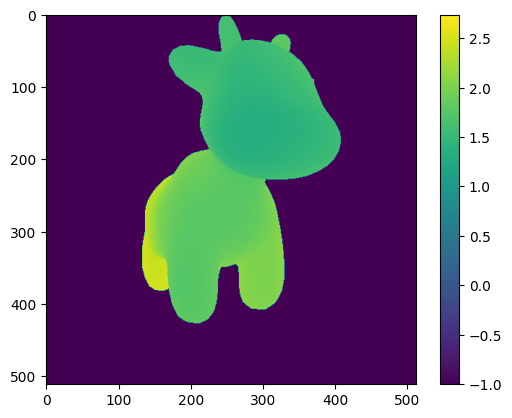

In [470]:
from util import ndc_grid

xy_ndc = ndc_grid(res)

# add depth channel
xy_depth = torch.stack([xy_ndc[0, ...], xy_ndc[1, ...], depth_map], dim=-1)

plt.imshow(depth_map)
plt.colorbar()

In [471]:
mask = depth_map != -1

xy_depth_points = xy_depth[mask]
point_features = feature_tensor[mask]

In [472]:
reprojected_points = cameras[0].unproject_points(
    xy_depth_points,
    world_coordinates=True,
    scaled_depth_input=False
)

mask = ~torch.isnan(reprojected_points).any(dim=1)
world_coords = reprojected_points[mask]

In [ ]:
distances = torch.cdist(
    world_coords,
    mesh.verts_list()[0],
    p=2
)

closest_vertex_indices = torch.argmin(distances, dim=1)
closest_vertex_indices

closest_vertex_indices

In [474]:
import rerun as rr
import rerun_util as ru

rr.init('debug', spawn=True)
rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

rr.log('cam', ru.pt3d_FovCamera(cameras, 0, res=res))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))
rr.log('cam', rr.Image(depth_map.cpu().numpy()))

rr.log('points', rr.Points3D(positions=world_coords, colors=point_features))

# log mesh
rr.log("mesh", ru.pt3d_mesh(mesh))


[2024-09-03T09:51:13Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
[2024-09-03T09:51:13Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:53504
